In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
import seaborn as sns

In [61]:
dfmain = pd.read_csv('bankfull_add.csv')

dfmain['education']=np.where(dfmain['education'] =='basic.9y', 'Basic', dfmain['education'])
dfmain['education']=np.where(dfmain['education'] =='basic.6y', 'Basic', dfmain['education'])
dfmain['education']=np.where(dfmain['education'] =='basic.4y', 'Basic', dfmain['education'])

In [62]:
enc = OneHotEncoder(handle_unknown='ignore')
X = dfmain[['job', 'marital', 'education', 'contact', 'month', 'day', 'poutcome']]
enc.fit(X)
enc.categories_
myvars = enc.transform(dfmain[['job', 'marital', 'education', 'contact', 'month', 'day', 'poutcome']]).toarray()
df2 = pd.DataFrame(myvars, columns=enc.get_feature_names_out(['job', 'marital', 'education', 'contact', 'month', 'day', 'poutcome']))
d = dict.fromkeys(df2.select_dtypes(np.float64).columns, np.int64)
df2 = df2.astype(d)

In [63]:
dfmain.drop(['job', 'marital', 'education', 'contact', 'month', 'day', 'poutcome'], axis=1, inplace=True)
df = pd.merge(dfmain, df2, right_index=True, left_index=True).dropna()

In [64]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#train/validation/test split
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split
RANDOM_STATE = 2018
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

In [65]:
target = 'y'
predictors = ['previous', 'euribor3m', 'job_housemaid', 'job_retired', 'job_student', 'marital_unknown', 'education_Basic', 
'education_illiterate', 'education_unknown', 'contact_cellular', 'contact_telephone', 'month_dec', 'month_jul', 
'month_jun', 'month_mar', 'month_may', 'month_oct', 'day_mon', 'poutcome_failure', 'poutcome_success']


train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

dtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values, feature_name=predictors)
dvalid = lgb.Dataset(valid_df[predictors].values, label=valid_df[target].values, feature_name=predictors)

# Random Forest (RF)

In [73]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)
							 
clf.fit(train_df[predictors], train_df[target].values)

preds = clf.predict(valid_df[predictors])

roc_auc = roc_auc_score(valid_df[target].values, preds)
print('Random Forest ROC_AUC = %.3f' % (roc_auc))

Random Forest ROC AUC = 0.624


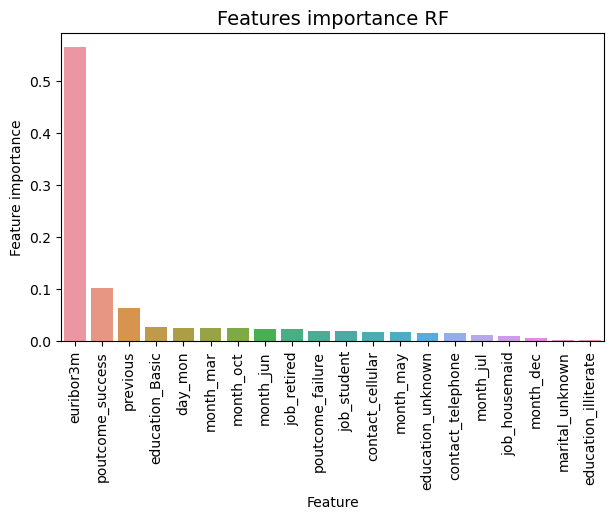

In [74]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance RF',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

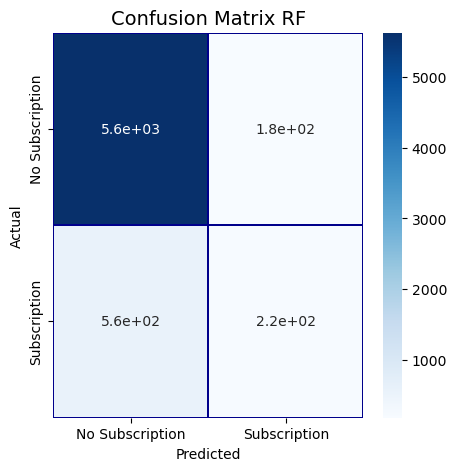

In [75]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['No Subscription', 'Subscription'],
            yticklabels=['No Subscription', 'Subscription'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix RF', fontsize=14)
plt.show()

# EXtreme Gradient Boosting (XGBoost) Model

In [40]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [43]:
# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
# params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [44]:
#Train the model
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.75784	valid-auc:0.75874
[50]	train-auc:0.79012	valid-auc:0.79325
[100]	train-auc:0.79586	valid-auc:0.79740
[150]	train-auc:0.79889	valid-auc:0.79960
[200]	train-auc:0.80124	valid-auc:0.80346
[250]	train-auc:0.80314	valid-auc:0.80591
[300]	train-auc:0.80443	valid-auc:0.80708
[350]	train-auc:0.80548	valid-auc:0.80755
[400]	train-auc:0.80655	valid-auc:0.80823
[450]	train-auc:0.80747	valid-auc:0.80846
[500]	train-auc:0.80827	valid-auc:0.80863
[550]	train-auc:0.80878	valid-auc:0.80890
[600]	train-auc:0.80942	valid-auc:0.80927
[650]	train-auc:0.81025	valid-auc:0.80968
[700]	train-auc:0.81095	valid-auc:0.81018
[750]	train-auc:0.81120	valid-auc:0.81006
[767]	train-auc:0.81126	valid-auc:0.81020


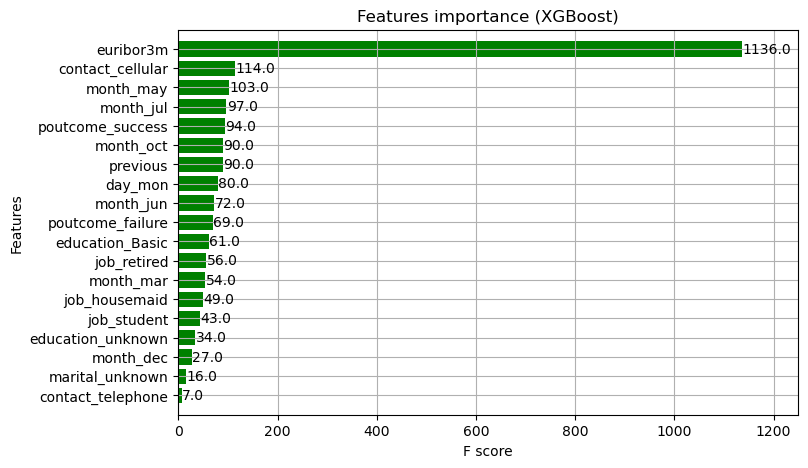

In [45]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [58]:
X = df.drop('y', axis=1)
y = df['y']

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10,
seed=123)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE XGBoost: %f" % (rmse))

RMSE XGBoost: 0.235911


I investigated the data, checked for data unbalanced record on the target variable, visualized the correlations with respect to the target variable and tried to understand the relationship between different features. I then created a Training Set for a Heavily Imbalanced Data Set using random under-sampling . After shuffling this newly created data set (8,406 records), I visualized the target variable (y) distribution once more to verify if I have a balanced data set between the number of subscriptions and no subscription. With the balanced sub-sample, I calculated the AUC_ROC score for the most  popular classification algorithms.

A few algorithms quite significantly outperformed the others. The XGBoost Classifier `(XGBM , score = 0.810)` and Random Forest (RF) Classifier `(RF, score = 0.624)`, Logistic Regression `(LR, score = 0.884)`. 

I therefore fitted these 3 models on a training set and validating the results on a test set, The split was 80/20.  I went back to the original data set for actual training and validation. 

After implementing he Logistic Regression, I tried the Extreme Gradient Boosting and Randome Forest Models for model comparison.

After performing over-sampling and Recursive features Elimination, I fitted a Logistic Regression Model to the data and obtained ROC of **0.884** on the test set. The RMSE of the Logistic Regression model was: **0.45**. With the Random Forest model the **AUC_ROC** was **0.624** the worst of the three models.

With the XGBoost model, I used the validation set for validation of the training model. The best validation score obtained was **0.810** which is lower ten what I obtained with the Logistic regression model. The Root Mean Squared Error was **0.2359**

Although the AUC_ROC of the Logistic Regression Model is higher than the one of the XGBoost Model, the RMSE of the XGBoost Model is significantly lower with a very good AUC_ROC of **0.810** as well, therefore the XGBoost Model outperformed all other models. 